# Checking adjacency : Dataset generation and visualization





## The adjacency problem

Recall that our puzzle pieces are squares pieces of the same dimensions coming from a single image. They each have a left edge (edge 0), top edge (edge 1), right edge (edge 2) and bottom edge (edge 3). 

__Definitions__

* We say piece P is the _i_ th neighbour of piece Q if P shares Q's edge _i_. Note that this would mean Q is P's _(i+2) mod 4_ th neighbour

* We say a tuple of puzzle pieces (P, Q) (order matters!) are __left-right adjacent__ if Q is P's 2nd neighbour (and equivalently, P is Q's 0-th neighbour). In other words, (P,Q) are __left-right adjacent__ if when P is placed to the left of Q, P's right edge is adjacent to Q's left edge.

Given a tuple (P,Q) of puzzle pieces from an image, the question we'd like to answer is:
      
             Is the tuple (P,Q) left-right adjacent ?

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import os

import pprint
import itertools
from collections import defaultdict

# generate random integer values
from random import seed
from random import randint
import numpy as np
#from pylab import array
from random import sample
import math

#pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms, utils


## Creating the dataset : An overview


### 1. Main puzzle image source
We create the dataset for this problem from the CUB-200 dataset: http://www.vision.caltech.edu/visipedia/CUB-200.html


### 2. Iterable dataset
We use Pytorch's IterableDataset class and customize it to generate our dataset. Using the IterableDataset class will mean that we need to give an iterator which when called will give out the next datapoint.


### 3. Idea
The idea is that we will look at each image in the CUB-200 dataset. If we make a grid of r rows and c cols from the image, the piece in row i and col j gets label (i,j). There are rc puzzle pieces and C(rc,2) pairs of puzzle pieces. 


Let distance between two puzzle_pieces be the euclidean distance between their labels. So distance between (0,1) and (2,3) labelled pieces = sqrt((2-0)^2 + (3-1)^2) = sqrt(8). Adjacent pieces are distance 1 apart. We calculate the distribution of distances .. (i.e given d, how many puzzle_piece_pairs are d distance apart).


Then we pick all the adjacent puzzle_piece_pairs and randomly pick non-adjacent puzzle_piece_pairs so that the distribution of distances among the non-adjacent puzzle_piece_pairs is maintained. This ensures we get roughly equal number of "adjacent" labels and equal number of "non_adjacent" labels in our dataset while also ensuring we get a variety of non_adjacent pairs (following a certain distribution)

For illustration, we define a custom dataset which outputs two puzzle pieces (P,Q) and the label (whether (P,Q) is left-right adjacent or not). 


### 4. A futher cropping
We also give the code for the actual dataset we will be using. There, we will further place P to the left of Q so that the right edge of P coincides with the left of Q and crop out a square piece around the shared edge. The cropped out piece will be rescaled to model-input dimensions  (__crop(P+Q)__). Thus our actual custom dataset which outputs the cropped recaled puzzle piece (__crop(P+Q)__) and the label (whether (P,Q) is left-right adjacent or not). 




## Shuffler 

### 1. A problem ?

We cannot "shuffle" our dataset if using the IterableDataset class as our iterator can only point to the "next" data point. If we make the dataset without shuffling, we'll probably process each image sequentially. From one image, we'll get a lot of data points (pairs of puzzle_pieces) which might make our model learn the specifics of one image rather than learning what "adjacency" is in general..

### 2. And a way out
The following is a helper function which takes as input an iterator and a buffer_size and returns an iterator. 



__What it does__ : it keeps getting the data from the original iterator and storing it in a buffer till buffer_size is achieved. Then it <i><b>shuffles<b></i> the data collected so far in the buffer and gives it out one by one when called. Once the buffer is empty, it again collects the data from the original iterator and stores it in the buffer till buffer_size is achieved and so on ...

In [2]:
def shuffle_buffer_iterator(actual_iterator, size_of_buffer):
    shuffle = []

    while(True):
        size = 0
        while(size < size_of_buffer):
            try:
                shuffle.append(next(actual_iterator))
                size +=1
            except StopIteration:
                shuffle = sample(shuffle, len(shuffle))    
                for s in shuffle:
                    yield s
                return
        
        shuffle = sample(shuffle, len(shuffle))    
        for s in shuffle:
            yield s
        shuffle = []

In [3]:
#Test to try out shuffle_buffer_iterator
a = iter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17, 18, 19,20,21,22])
b = shuffle_buffer_iterator(a, 5)
for x in b:
    print(f"{x}," , end ='')

4,3,5,1,2,7,10,6,8,9,12,13,14,15,11,20,17,19,16,18,22,21,

## Custom dataset : Code

#### Inputs
<ul>
    <li>root_dir : the root directory where the CUB-200 images are stored </li>
<li> sq_puzzle_piece_dim : the dimension of the square puzzle piece (recall we cut the original image into uniform square puzzle pieces) </li>
    <li> size_of_buffer : the buffer size for our shuffle_iterator</li>
    <li> model_dim : input size for the model</li>
 </ul>
 
#### Output
<ul>
    <li> juxtaposed_pieces_torchtensor : square cropped rescaled piece with width, height = model_dim <li>
    <li> label : 1 if left-right adjacent, 0 if not</li>
</ul>

In [4]:
class AdjacencyDataset(IterableDataset):
    def __init__(self, root_dir, sq_puzzle_piece_dim, size_of_buffer, model_dim):
        super(IterableDataset).__init__()
        self.root_dir = root_dir
        self.sq_puzzle_piece_dim = sq_puzzle_piece_dim
        self.size_of_buffer = size_of_buffer
        self.model_dim = model_dim
        

    def make_the_puzzle_grid(self, rows, cols):
        list_of_labels = []
        for x in range(rows):
            for y in range(cols):
                list_of_labels.append((x,y))

        dist_dict = defaultdict(list)
        for pos, (x, y) in enumerate(list_of_labels):
            for a,b in list_of_labels[pos+1: ]:
                d = (a-x)**2 + (b-y)**2
                dist_dict[d].append([(x,y), (a,b)])

        size_dist_dict = {}
        for d in dist_dict:
            size_dist_dict[d] = len(dist_dict[d])

        no_of_non_adjacent_pairs = 0
        for d in size_dist_dict:
            no_of_non_adjacent_pairs += size_dist_dict[d]
        no_of_non_adjacent_pairs -= size_dist_dict[1]
        no_of_adjacent_pairs = size_dist_dict[1]

        #There are no_of_non_adjacent_pairs non-adjacent pairs.
        #How to choose no_of_adjacent_pairs  pairs of non-adjacent pieces ?
        #no_of_non_adjacent_pairs*x = no_of_adjacent_pairs

        x  = no_of_adjacent_pairs/no_of_non_adjacent_pairs
        no_of_rep = {}
        for d in size_dist_dict:
            no_of_rep[d] = math.ceil(size_dist_dict[d]*x)
        no_of_rep[1] = size_dist_dict[1]

        return list_of_labels, dist_dict, size_dist_dict, no_of_rep
    
    def transform_input(self, piece_1, piece_2):
        width = self.model_dim
        height = self.model_dim
        piece_1 = piece_1.resize((width, height))
        piece_2 = piece_2.resize((width, height))
        juxtaposed = Image.new('RGB', (2*width, height), color=0)
        #juxtaposed.paste(piece_i ,
        #(left_upper_row, left_upper_col, 
        #right_lower_row, right_lower_col))
        juxtaposed.paste(piece_1,(0,0,width, height))
        juxtaposed.paste(piece_2,(width,0,2*width, height))
        juxtaposed = juxtaposed.crop((width//2, 0,width//2 + width,height))
        return transforms.ToTensor()(juxtaposed)

        
        
        


    def puzzle_piece_pair_iterator(self):
        for folder in sample(os.listdir(self.root_dir), len(os.listdir(self.root_dir))):
            folder_path = self.root_dir+"/"+folder
            for image in sample(os.listdir(folder_path), len(os.listdir(folder_path))):
                current_bird_image = Image.open(folder_path + "/"+image)
                
                original_image_height = current_bird_image.size[1]
                original_image_width =  current_bird_image.size[0] 
                
                puzzle_piece_height = self.sq_puzzle_piece_dim
                puzzle_piece_width = self.sq_puzzle_piece_dim
                
                rows = round(original_image_height/puzzle_piece_height)
                cols = round(original_image_width/puzzle_piece_width)
                
                list_of_labels, dist_dict, size_dist_dict, no_of_rep = self.make_the_puzzle_grid(rows,cols) 
                
                new_image_height = rows*puzzle_piece_height
                new_image_width = cols*puzzle_piece_width
                
                current_bird_image = current_bird_image.resize((new_image_width, new_image_height))
                
                puzzle_pieces = []
                i = 0
                j = 0
                while(i < rows):
                    row_puzzle_pieces = []
                    row_puzzle_pieces_torchtensor = []
                    while(j < cols):
                        crop_piece = current_bird_image.crop((j*puzzle_piece_width,i*puzzle_piece_height,(j+1)*puzzle_piece_width,(i+1)*puzzle_piece_height))
                        row_puzzle_pieces.append(crop_piece)
                        j += 1
                    puzzle_pieces.append(row_puzzle_pieces)
                    i += 1
                    j = 0
                puzzle_piece_crop_list = []
                for d in dist_dict:
                    puzzle_piece_crop_list.extend(sample(dist_dict[d], no_of_rep[d]))
                
                for label_pairs in sample(puzzle_piece_crop_list, len(puzzle_piece_crop_list)):
                    x, y = label_pairs[0]
                    a, b = label_pairs[1]
                    are_adjacent = (((x-a)**2 + (y-b)**2)==1)
                    piece_1 = puzzle_pieces[x][y]
                    piece_2 = puzzle_pieces[a][b]
                    if are_adjacent:
                        if abs(a-x)==1:
                            #rotate piece_1_torchtensor counterclockwise by 90
                            #rotate piece_2_torchtensor counterclockwise by 90
                            piece_1 = puzzle_pieces[x][y].rotate(90)
                            piece_2 = puzzle_pieces[a][b].rotate(90)
                    if are_adjacent:
                        label = 1
                    else:
                        label = 0
                    
                    juxtaposed_pieces_torchtensor = self.transform_input(piece_1, piece_2)
                    yield (juxtaposed_pieces_torchtensor,label)
            
    def __iter__(self):
        my_iterator = self.puzzle_piece_pair_iterator()
        return shuffle_buffer_iterator(my_iterator, self.size_of_buffer)

    
    
        

## Examples : Dataset and Dataloader

In [5]:
my_root_dir = os.getenv("MY_ROOT_DIR")
my_sq_puzzle_piece_dim = 100
my_size_of_buffer = 500
my_model_dim = 100
my_batch_size = 1

In [6]:
my_adjacency_dataset = AdjacencyDataset(my_root_dir, my_sq_puzzle_piece_dim, 
                                        my_size_of_buffer, my_model_dim)

In [7]:
my_adjacency_dataloader = DataLoader(my_adjacency_dataset, my_batch_size)

 Label : 0



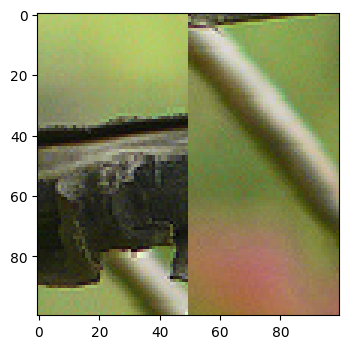

*****************
 Label : 1



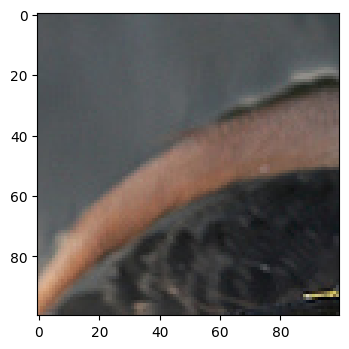

*****************
are_adjacent 6
are_not_adjacent 4


In [8]:
labels_seen = [0,0]
for i in range(10):
    juxtaposed_pieces_torchtensor,label = next(iter(my_adjacency_dataloader))
    juxtaposed_pieces_image = transforms.ToPILImage()(juxtaposed_pieces_torchtensor.squeeze(0))
    current_label = label.item()
    if (current_label == 0 and labels_seen[0]==0) or (current_label == 1 and labels_seen[1] == 0):
        print(f" Label : {current_label}")
        print()
        my_dpi = 100 #seems to be the font size + line thickness
        fig = plt.figure(dpi = my_dpi)
        ax=fig.add_subplot(1,1,1)
        ax.imshow(juxtaposed_pieces_image)
        plt.show()
        print("*****************")
    labels_seen[current_label] += 1
        


    
print(f"are_adjacent {labels_seen[1]}")
print(f"are_not_adjacent {labels_seen[0]}")


## Custom dataset for illustation : Code



In [9]:
class IllustrativeAdjacencyDataset(IterableDataset):
    def __init__(self, root_dir, sq_puzzle_piece_dim, size_of_buffer):
        super(IterableDataset).__init__()
        self.root_dir = root_dir
        self.sq_puzzle_piece_dim = sq_puzzle_piece_dim
        self.size_of_buffer = size_of_buffer
        
    def make_the_puzzle_grid(self, rows, cols):
        list_of_labels = []
        for x in range(rows):
            for y in range(cols):
                list_of_labels.append((x,y))

        dist_dict = defaultdict(list)
        for pos, (x, y) in enumerate(list_of_labels):
            for a,b in list_of_labels[pos+1: ]:
                d = (a-x)**2 + (b-y)**2
                dist_dict[d].append([(x,y), (a,b)])

        size_dist_dict = {}
        for d in dist_dict:
            size_dist_dict[d] = len(dist_dict[d])

        no_of_non_adjacent_pairs = 0
        for d in size_dist_dict:
            no_of_non_adjacent_pairs += size_dist_dict[d]
        no_of_non_adjacent_pairs -= size_dist_dict[1]
        no_of_adjacent_pairs = size_dist_dict[1]

        #There are no_of_non_adjacent_pairs non-adjacent pairs.
        #How to choose no_of_adjacent_pairs  pairs of non-adjacent pieces ?
        #no_of_non_adjacent_pairs*x = no_of_adjacent_pairs

        x  = no_of_adjacent_pairs/no_of_non_adjacent_pairs
        no_of_rep = {}
        for d in size_dist_dict:
            no_of_rep[d] = math.ceil(size_dist_dict[d]*x)
        no_of_rep[1] = size_dist_dict[1]

        return list_of_labels, dist_dict, size_dist_dict, no_of_rep



        
    
    def puzzle_piece_pair_iterator(self):
        for folder in os.listdir(self.root_dir):
            folder_path = self.root_dir+"/"+folder
            for image in os.listdir(folder_path):
                current_bird_image = Image.open(folder_path + "/"+image)
                
                original_image_height = current_bird_image.size[1]
                original_image_width =  current_bird_image.size[0] 
                
                puzzle_piece_height = self.sq_puzzle_piece_dim
                puzzle_piece_width = self.sq_puzzle_piece_dim
                
                rows = round(original_image_height/puzzle_piece_height)
                cols = round(original_image_width/puzzle_piece_width)
                
                list_of_labels, dist_dict, size_dist_dict, no_of_rep = self.make_the_puzzle_grid(rows,cols) 
                
                new_image_height = rows*puzzle_piece_height
                new_image_width = cols*puzzle_piece_width
                
                current_bird_image = current_bird_image.resize((new_image_width, new_image_height))
                
                puzzle_pieces = []
                puzzle_pieces_torchtensor = []
                i = 0
                j = 0
                while(i < rows):
                    row_puzzle_pieces = []
                    row_puzzle_pieces_torchtensor = []
                    while(j < cols):
                        crop_piece = current_bird_image.crop((j*puzzle_piece_width,i*puzzle_piece_height,(j+1)*puzzle_piece_width,(i+1)*puzzle_piece_height))
                        row_puzzle_pieces.append(crop_piece)
                        row_puzzle_pieces_torchtensor.append(transforms.ToTensor()(crop_piece))
                        j += 1
                    puzzle_pieces.append(row_puzzle_pieces)
                    puzzle_pieces_torchtensor.append(row_puzzle_pieces_torchtensor)
                    i += 1
                    j = 0
                puzzle_piece_crop_list = []
                for d in dist_dict:
                    puzzle_piece_crop_list.extend(sample(dist_dict[d], no_of_rep[d]))
                
                for label_pairs in sample(puzzle_piece_crop_list, len(puzzle_piece_crop_list)):
                    x, y = label_pairs[0]
                    a, b = label_pairs[1]
                    are_adjacent = (((x-a)**2 + (y-b)**2)==1)
                    piece_1_torchtensor = puzzle_pieces_torchtensor[x][y]
                    piece_2_torchtensor = puzzle_pieces_torchtensor[a][b]
                    if are_adjacent:
                        if abs(a-x)==1:
                            #rotate piece_1_torchtensor counterclockwise by 90
                            #rotate piece_2_torchtensor counterclockwise by 90
                            piece_1 = puzzle_pieces[x][y].rotate(90)
                            piece_2 = puzzle_pieces[a][b].rotate(90)
                            piece_1_torchtensor = transforms.ToTensor()(piece_1)
                            piece_2_torchtensor = transforms.ToTensor()(piece_2)
                            
                    #we are returning a lot of needless information, because we want to visualize what is going on
                    #Actually we only need to return (piece_1_torchtensor,piece_2_torchtensor,are_adjacent)
                    yield (transforms.ToTensor()(current_bird_image), rows, cols, (x,y), (a,b), piece_1_torchtensor,piece_2_torchtensor,are_adjacent)
            
    def __iter__(self):
        my_iterator = self.puzzle_piece_pair_iterator()
        return shuffle_buffer_iterator(my_iterator, self.size_of_buffer)

    
    
        

## Visualizations

In [10]:
# Helper function to show a data_point

def visualize(current_bird_image_torchtensor, rows, cols, point_1, point_2, piece_1_torchtensor,piece_2_torchtensor,are_adjacent):
    #Draw the puzzle grid with each piece labelled
    (x,c,h,w) = current_bird_image_torchtensor.size()
    #convert the 1 x C x H x W tensor into a C x H x W tensor
    modified_bird_image_torchtensor = current_bird_image_torchtensor.view(c,h,w) 
    current_bird_image = transforms.ToPILImage()(modified_bird_image_torchtensor)
    
    
     
    (x,c,h,w) = piece_1_torchtensor.size()
    #convert the 1 x C x H x W tensor into a C x H x W tensor
    modified_piece_1_torchtensor = piece_1_torchtensor.view(c,h,w) 
    piece_1_image = transforms.ToPILImage()(modified_piece_1_torchtensor)
    
    
    (x,c,h,w) = piece_2_torchtensor.size()
    #convert the 1 x C x H x W tensor into a C x H x W tensor
    modified_piece_2_torchtensor = piece_2_torchtensor.view(c,h,w) 
    piece_2_image = transforms.ToPILImage()(modified_piece_2_torchtensor)
    
    
    a = point_1[0].item()
    b = point_1[1].item()
    c = point_2[0].item()
    d = point_2[1].item()
    
    pos_1 = 2
    pos_2 = 1
    
    if c == a+1 and b==d:
        #Draw Piece_1 and Piece_2 in the Up-down orientation
        piece_1_image = piece_1_image.rotate(270)
        piece_2_image = piece_2_image.rotate(270)
        pos_1 = 1
        pos_2 = 2
    
    
    
    # Set up figure
    my_dpi = 100 #seems to be the font size + line thickness
    #fig=plt.figure(figsize=(float(w)/my_dpi,float(h)/my_dpi),dpi=my_dpi)
    fig = plt.figure(dpi = my_dpi)
    
    #subplot(mni) breaks the figure window into an m-by-n matrix of small subplots
    #and selects the i_th subplot for the current plot. 
    #The plots are numbered along the top row of the figure window, then the second row, and so forth.
    
    ax=fig.add_subplot(pos_1,pos_2,1)
    
    # Remove whitespace from around the image
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    
    
    # Set the gridding interval: here we use the major tick interval
    #Within each axis, there is the concept of a major tick mark, and a minor tick mark. 
    #As the names would imply, major ticks are usually bigger or more pronounced,
    #while minor ticks are usually smaller. 
    
    #For a basic tutorial on plt.ticks - https://www.geeksforgeeks.org/python-matplotlib-pyplot-ticks/
    
    #each tick is 100 units apart
    #https://matplotlib.org/3.1.1/gallery/ticks_and_spines/tick-locators.html
    myInterval=100.
    loc = plticker.MultipleLocator(base=myInterval)
    
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    
    # Add the grid
    ax.grid(which='major', axis='both', linestyle='-',color='white')
    
    # Add the image
    ax.imshow(current_bird_image)

    # Find number of gridsquares in x and y direction
    nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
    ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))
    
    #nx = cols
    #ny = rows


    # Add some labels to the gridsquares
    for i in range(rows):
        y=myInterval/2+i*myInterval
        for j in range(cols):
            x=myInterval/2.+float(j)*myInterval
            ax.text(x,y,'({:d},{:d})'.format(i,j),color='red',ha='center',va='center')

    # Save the figure
    #fig.savefig('current_bird_image_grid.jpeg',dpi=my_dpi)

    
    
   
    
    
    if c == a+1 and b==d:
        #Draw Piece_1 and Piece_2 in the Up-down orientation
        ax=fig.add_subplot(222)
        ax.imshow(piece_1_image)
        plt.axis('off')
        ax.text(50,50,'({:d},{:d})'.format(a,b),color='red',ha='center',va='center')
        ax=fig.add_subplot(224)
        ax.imshow(piece_2_image)
        plt.axis('off')
        ax.text(50,50,'({:d},{:d})'.format(c,d),color='red',ha='center',va='center')


        
    else:
        #Draw Piece_1 and Piece_2 in the L-R orientation or Up-down orientation depending on the piece. 
        ax=fig.add_subplot(223)
        ax.imshow(piece_1_image)
        plt.axis('off')
        ax.text(50,50,'({:d},{:d})'.format(a,b),color='red',ha='center',va='center')
        ax=fig.add_subplot(224)
        ax.imshow(piece_2_image)
        plt.axis('off')
        ax.text(50,50,'({:d},{:d})'.format(c,d),color='red',ha='center',va='center')



    
    
    
    plt.show()
       
  
    
    #Print if they are adjacent or not 
    print(f"are_adjacent is {are_adjacent.item()}")

    
    

In [11]:
my_illustrative_adjacency_dataset = IllustrativeAdjacencyDataset(my_root_dir,
                                                                 my_sq_puzzle_piece_dim, 
                                                                 my_size_of_buffer)
my_illustrative_adjacency_dataloader = DataLoader(my_illustrative_adjacency_dataset, 
                                                  my_batch_size)


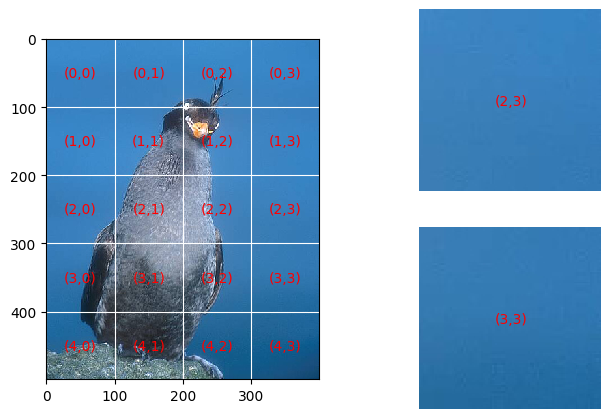

are_adjacent is True


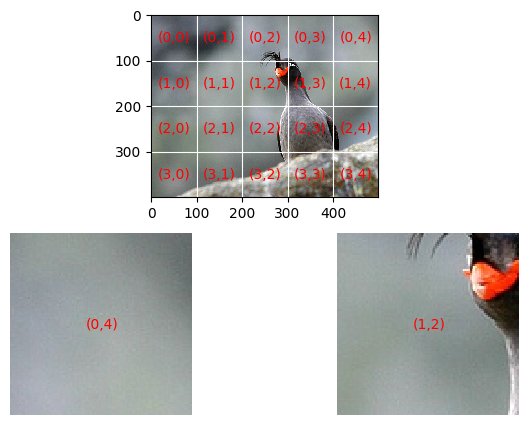

are_adjacent is False


In [12]:
no_of_data_points_seen = 0
are_adjacent = 0
are_not_adjacent = 0
for data_point in iter(my_illustrative_adjacency_dataloader):
        data_answer = [*data_point][-1]
        if data_answer:
            if are_adjacent == 0:
                visualize(*data_point)                
            are_adjacent += 1
        else:
            if are_not_adjacent == 1:
                visualize(*data_point)            
            are_not_adjacent += 1
        no_of_data_points_seen += 1
        if no_of_data_points_seen >= 10:
            break
            


In [13]:
print(f"are_adjacent {are_adjacent}")
print(f"are_not_adjacent {are_not_adjacent}")

are_adjacent 5
are_not_adjacent 5
